In [1]:
import os
import time
import wfdb

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', 500)

In [2]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce GTX 1070 is available.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
# Ruta al archivo CSV de anotaciones (asegúrate de ajustar la ruta)
data_dir = '../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'  # Directorio donde están los archivos .dat
annotations_file = os.path.join(data_dir,'df_info_ptbdb_xl.csv')

# Cargar el archivo CSV con etiquetas y metadatos
df = pd.read_csv(annotations_file)
df


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass,NOT_NORM
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,NORM,0
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,NORM,0
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,NORM,0
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,NORM,0
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,NORM,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",LAD,NaN,NaN,1.0,False,True,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,NDT,1
21833,21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",MID,Stadium II-III,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,NORM,0
21834,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,"{'ISCAS': 50.0, 'SR': 0.0}",MID,NaN,NaN,1.0,True,True,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,ISCAS,1
21835,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,supraventrikulÄre extrasystole(n) sinusrhythmu...,"{'NORM': 100.0, 'SR': 0.0}",LAD,NaN,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,NORM,0


In [9]:
def read_ecg(file_name):
    #file_name='s0426_re'
    sigs, fields = wfdb.rdsamp(file_name, channels=[i for i in range(12)], sampfrom=0, #sampto=6000
                              )
    #display(pd.DataFrame(sigs).iplot())
    return pd.DataFrame(sigs  ,columns=fields['sig_name'] )

In [11]:
%%time
# Función para cargar datos de ECG en formato .dat
def load_ecg_data(df, data_dir):
    signals = []
    labels = []

    for idx, row in df.iterrows():
        # Leer el archivo .dat correspondiente
        record = wfdb.rdsamp(data_dir + row['filename_hr'].replace('.mat', ''))
        
        # Extraer señales de ECG y etiqueta
        ecg_signal = record[0]  # Record[0] es el array de señales, (muestras, derivaciones)
        #label = row['diagnostic_superclass']  # Ejemplo: una columna con clases principales
        
        label = row['NOT_NORM']  # Ejemplo: una columna con clases principales
        # Asegúrate de que las señales sean de una longitud fija para el modelo
        if ecg_signal.shape[0] >= 1000:  # Suponiendo un mínimo de 1000 muestras
            ecg_signal = ecg_signal[:1000, :]  # Truncar o seleccionar la longitud deseada
        else:
            # Relleno con ceros si es más corto
            ecg_signal = np.pad(ecg_signal, ((0, 1000 - ecg_signal.shape[0]), (0, 0)), 'constant')

        signals.append(ecg_signal)
        labels.append(label)

    # Convertir listas a arrays de NumPy
    signals = np.array(signals)
    labels = np.array(labels)

    return signals, labels

# Cargar los datos y etiquetas
signals, labels = load_ecg_data(df, data_dir)

CPU times: total: 1min 42s
Wall time: 6min 56s


In [12]:
signals.shape

(21837, 1000, 12)

In [13]:
%%time
# Crear un mapeo de etiquetas a números
label_mapping = {label: idx for idx, label in enumerate(df['diagnostic_superclass'].unique())}
print(label_mapping)
#df['label'] = df['diagnostic_superclass'].map(label_mapping)
#labels=[label_mapping[line] for line in labels]
#labels=np.array(labels)

{'NORM': 0, 'IMI': 1, 'unknown': 2, 'NDT': 3, 'NST_ and DIG': 4, 'LVH': 5, 'LPFB': 6, 'LNGQT and NST_ and DIG': 7, 'LAFB': 8, 'IRBBB': 9, 'IVCD': 10, 'ASMI': 11, 'NDT and IRBBB': 12, '1AVB': 13, 'ISCAL': 14, 'LVH and ISC_': 15, '1AVB and NDT': 16, 'ISCLA': 17, 'ISCIL': 18, 'ILMI': 19, 'NST_': 20, 'LAFB and ISC_': 21, 'CRBBB and LAFB': 22, 'CLBBB': 23, 'ASMI and ALMI': 24, 'LAFB and 1AVB': 25, 'ILMI and ASMI': 26, 'ISCAS': 27, 'ASMI and ILMI': 28, 'LVH and 1AVB': 29, 'CRBBB': 30, 'RAO/RAE': 31, 'NDT and 1AVB': 32, 'RVH and RAO/RAE and IRBBB': 33, 'ASMI and ANEUR and 1AVB': 34, 'NORM and LAFB': 35, 'LNGQT and LAFB': 36, 'ALMI and LAFB': 37, 'IMI and CRBBB': 38, 'ASMI and IMI': 39, 'ASMI and LVH and ISC_': 40, 'ISC_ and LVH': 41, 'ASMI and ALMI and IMI and LAFB': 42, 'ASMI and ILBBB and ISC_': 43, 'LVH and ISC_ and DIG': 44, 'ISCIN': 45, 'NDT and LAFB': 46, 'ASMI and CRBBB': 47, 'AMI': 48, 'EL': 49, 'LNGQT': 50, 'CLBBB and 1AVB': 51, 'ISC_ and 1AVB': 52, 'ISC_ and LVH and IVCD': 53, 'unkn

In [15]:

X_train, X_test, y_train, y_test = train_test_split(signals, labels, test_size=0.3, random_state=123)

# Convertir a tensores de PyTorch con la forma (n_samples, n_channels, seq_length)
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1).to('cuda')
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1).to('cuda')
y_train = torch.tensor(y_train, dtype=torch.long).to('cuda')
y_test = torch.tensor(y_test, dtype=torch.long).to('cuda')

In [16]:

# Confirmar que la forma es correcta
print("Shape of X_train after permutation:", X_train.shape)
print("Shape of X_test after permutation:", X_test.shape)


Shape of X_train after permutation: torch.Size([15285, 12, 1000])
Shape of X_test after permutation: torch.Size([6552, 12, 1000])


In [17]:
y_train

tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0')

In [18]:
len(set(y_train.cpu().numpy()))

2

In [19]:
# Verificar forma de las etiquetas
print("Shape of y_train:", y_train.shape)  # Debe ser (17469,)


Shape of y_train: torch.Size([15285])


In [20]:
# cómo imprimir el sumarry
# entender arquitectura, normalmente no se usan capas nn.Linear en la 
# revisar predicciones puntuales
#  ver en que momento me lo regresa a dos

In [21]:
# Longitud de salida= (Longitud de entrada−Tamaño del kernel+2×Padding)/Stride  +1
# Donde:

# Longitud de entrada es el tamaño de la señal o vector de entrada.
# Tamaño del kernel es el tamaño de la ventana de la convolución (en este caso kernel_size=5).
# Padding es la cantidad de ceros que se agregan alrededor de la señal antes de la convolución.
# Stride es el número de posiciones que la ventana se desplaza a lo largo de la entrada.

In [22]:
import torch.nn.functional as F
class ECGCNN(nn.Module):
    def __init__(self, num_classes):
        super(ECGCNN, self).__init__()
        self.apply_softmax = apply_softmax  # Bandera para aplicar Softmax
        
        # Bloque convolucional
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Capa Transformer
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=1)

        # Capas densas
        self.fc1 = nn.Linear(64 * 247, 128)  # Cambia esto a 64 * 247
        self.fc2 = nn.Linear(128, num_classes)
        
        # Funciones de activación y regularización
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> Pool
        x = x.view(-1, 64 * 247)  # Asegúrate de que la forma sea correcta aquí
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [23]:
import torch.nn.functional as F
class ECGCNN(nn.Module):
    def __init__(self, num_classes):
        super(ECGCNN, self).__init__()
        
        # Bloque convolucional
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Capa Transformer
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=1)

        # Capas densas
        self.fc1 = nn.Linear(64 * 247, 128)  # Cambia esto a 64 * 247
        self.fc2 = nn.Linear(128, num_classes)
        
        # Funciones de activación y regularización
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        # Paso 1: Bloque convolucional
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling
        
        # Paso 2: Transformer
        #x = x.permute(2, 0, 1)  # Transformar [batch_size, 64, seq_length] -> [seq_length, batch_size, 64]
        #x = self.transformer_encoder(x)
        #x = x.permute(1, 2, 0)  # Volver a [batch_size, 64, seq_length_reducido]
        
        # Paso 3: Aplanar y capas densas
        x = x.contiguous().view(x.size(0), -1)  # Aplanar [batch_size, features]
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Última capa densa

        
        x = F.softmax(x, dim=1)
            
        return x


In [24]:
from torch.utils.data import DataLoader, TensorDataset

In [25]:
# Supongamos que y_train y y_test son tensores con las etiquetas correspondientes
# Asegúrate de que y_train y y_test sean de tipo LongTensor
y_train = torch.tensor(y_train, dtype=torch.long)  # Asegúrate de tener las etiquetas correctamente
y_test = torch.tensor(y_test, dtype=torch.long)

# Crear TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Crear DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


C:\Users\Dbhpr\AppData\Local\Temp\ipykernel_2392\1053173183.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)  # Asegúrate de tener las etiquetas correctamente
C:\Users\Dbhpr\AppData\Local\Temp\ipykernel_2392\1053173183.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


In [42]:
y_train


tensor([1, 0, 0,  ..., 0, 1, 1], device='cuda:0')

In [99]:
%%time
# Definir hiperparámetros
num_classes = len(set(y_train.cpu().numpy()))
num_epochs = 40
learning_rate = 0.001

# Inicializar el modelo, el optimizador y la función de pérdida
model = ECGCNN(num_classes)
model = model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_values=[]
# Entrenar el modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)  # Salidas del modelo
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Retropropagación
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    loss_values.append(average_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


C:\Users\Dbhpr\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/40], Loss: 0.5630
Epoch [2/40], Loss: 0.5227
Epoch [3/40], Loss: 0.5097
Epoch [4/40], Loss: 0.4978
Epoch [5/40], Loss: 0.4888
Epoch [6/40], Loss: 0.4803
Epoch [7/40], Loss: 0.4789
Epoch [8/40], Loss: 0.4671
Epoch [9/40], Loss: 0.4587
Epoch [10/40], Loss: 0.4506
Epoch [11/40], Loss: 0.4426
Epoch [12/40], Loss: 0.4365
Epoch [13/40], Loss: 0.4321
Epoch [14/40], Loss: 0.4244
Epoch [15/40], Loss: 0.4155
Epoch [16/40], Loss: 0.4140
Epoch [17/40], Loss: 0.4105
Epoch [18/40], Loss: 0.4090
Epoch [19/40], Loss: 0.4047
Epoch [20/40], Loss: 0.4045
Epoch [21/40], Loss: 0.3990
Epoch [22/40], Loss: 0.3980
Epoch [23/40], Loss: 0.3958
Epoch [24/40], Loss: 0.3979
Epoch [25/40], Loss: 0.3912
Epoch [26/40], Loss: 0.3855
Epoch [27/40], Loss: 0.3884
Epoch [28/40], Loss: 0.3921
Epoch [29/40], Loss: 0.3896
Epoch [30/40], Loss: 0.3843
Epoch [31/40], Loss: 0.3828
Epoch [32/40], Loss: 0.3810
Epoch [33/40], Loss: 0.3805
Epoch [34/40], Loss: 0.3803
Epoch [35/40], Loss: 0.3800
Epoch [36/40], Loss: 0.3790
E

In [100]:
#print arquitecture


In [101]:
import matplotlib.pyplot as plt

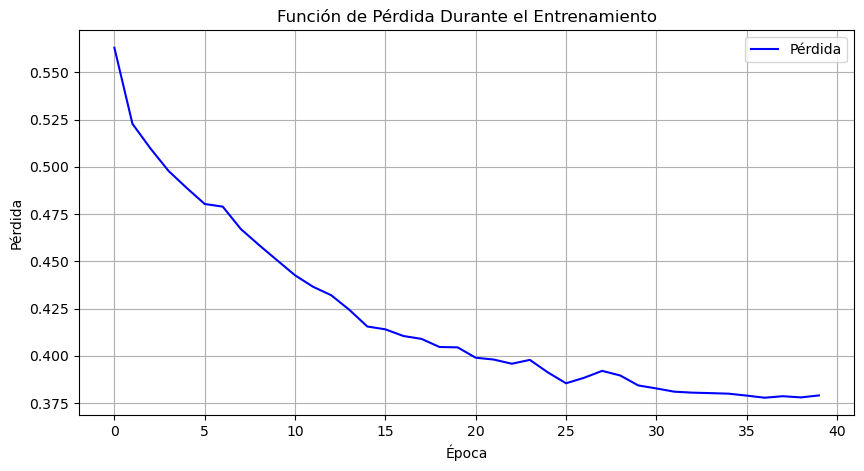

In [102]:
# Graficar la función de pérdida
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Pérdida', color='blue')
plt.title('Función de Pérdida Durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()


In [103]:
test_loader

In [104]:
model.eval()  # Modo evaluación
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')


Accuracy of the model on the test set: 80.11%


In [106]:
test_loader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


In [107]:
model.eval()  # Modo evaluación
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')


Accuracy of the model on the test set: 80.11%


In [108]:
predicted

tensor([0, 0, 0,  ..., 0, 0, 1], device='cuda:0')

In [109]:
print(model)

ECGCNN(
  (conv1): Conv1d(12, 32, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLine

In [110]:
labels

tensor([0, 0, 0,  ..., 0, 0, 1], device='cuda:0')

In [111]:
_

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [112]:
predicted

tensor([0, 0, 0,  ..., 0, 0, 1], device='cuda:0')

In [113]:
outputs.shape

torch.Size([6552, 2])

In [114]:
outputs

tensor([[1.0000e+00, 5.0694e-14],
        [1.0000e+00, 1.6258e-08],
        [1.0000e+00, 1.1897e-09],
        ...,
        [1.0000e+00, 8.4742e-20],
        [1.0000e+00, 2.8085e-11],
        [4.0504e-13, 1.0000e+00]], device='cuda:0')

In [117]:
from torchsummary import summary

# Supón que tu entrada tiene la forma (batch_size, num_channels, length)
input_size = (12, 1000)  # 12 canales, longitud 1000
summary(model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 996]           1,952
              ReLU-2              [-1, 32, 996]               0
         MaxPool1d-3              [-1, 32, 498]               0
            Conv1d-4              [-1, 64, 494]          10,304
              ReLU-5              [-1, 64, 494]               0
         MaxPool1d-6              [-1, 64, 247]               0
            Linear-7                  [-1, 128]       2,023,552
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                    [-1, 2]             258
Total params: 2,036,066
Trainable params: 2,036,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.21
Params size (MB): 7.77
Estimat

In [119]:
outputs

tensor([[1.0000e+00, 5.0694e-14],
        [1.0000e+00, 1.6258e-08],
        [1.0000e+00, 1.1897e-09],
        ...,
        [1.0000e+00, 8.4742e-20],
        [1.0000e+00, 2.8085e-11],
        [4.0504e-13, 1.0000e+00]], device='cuda:0')

In [120]:
y_pred = outputs
y_probs = torch.softmax(y_pred, dim=1)[:, 1]
y_pred_labels = torch.argmax(y_pred, dim=1)

# Mover los datos a CPU y convertirlos a NumPy
#y_true_np = y_test.cpu().numpy()
y_true_np = labels.cpu().numpy()
y_pred_np = y_pred_labels.cpu().numpy()
y_probs_np = y_probs.cpu().numpy()


In [121]:
labels

tensor([0, 0, 0,  ..., 0, 0, 1], device='cuda:0')

In [122]:
len(y_true_np)

6552

In [123]:
y_probs_np

array([0.26894143, 0.26894143, 0.26894143, ..., 0.26894143, 0.26894143,
       0.73105854], dtype=float32)

In [124]:

# Métricas de desempeño
from sklearn.metrics import classification_report, roc_auc_score
print("Reporte de Clasificación:")
print(classification_report(y_true_np, y_pred_np))

# ROC AUC
roc_auc = roc_auc_score(y_true_np, y_probs_np)
print(f"ROC AUC: {roc_auc:.4f}")

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      2712
           1       0.83      0.82      0.83      3840

    accuracy                           0.80      6552
   macro avg       0.79      0.80      0.80      6552
weighted avg       0.80      0.80      0.80      6552

ROC AUC: 0.8533


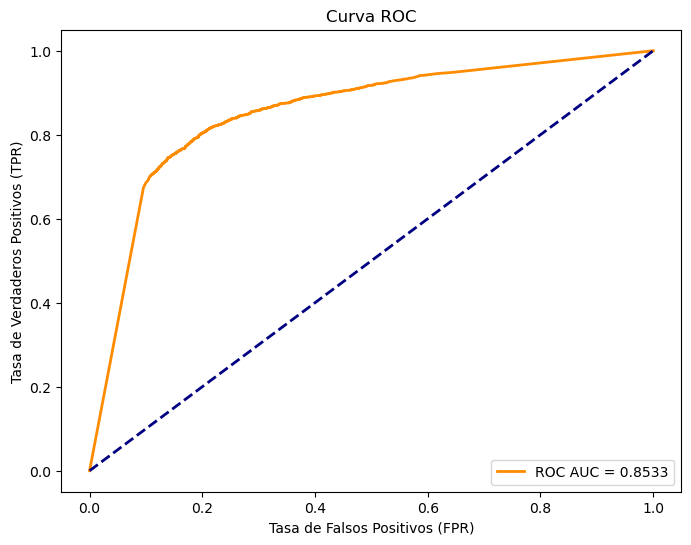

In [125]:
from sklearn.metrics import roc_curve

# Calcular los puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(y_true_np, y_probs_np)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

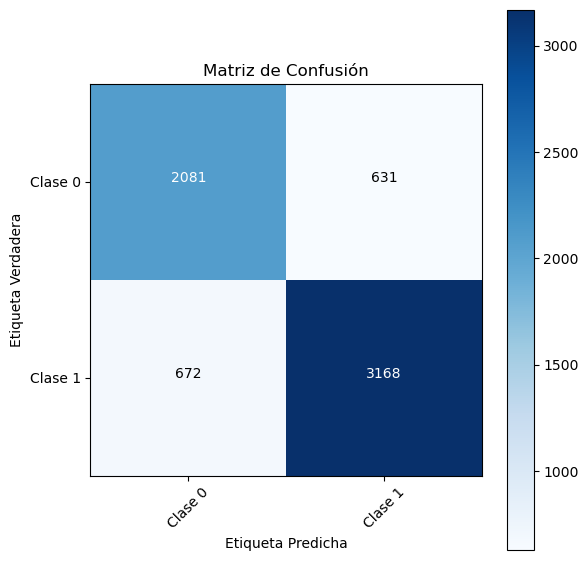

In [126]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_np, y_pred_np)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.colorbar()

classes = ["Clase 0", "Clase 1"]
tick_marks = range(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Etiquetas dentro de la matriz
thresh = conf_matrix.max() / 2
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, f"{conf_matrix[i, j]}", 
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel("Etiqueta Verdadera")
plt.xlabel("Etiqueta Predicha")
plt.tight_layout()
plt.show()

In [157]:
import torch
from torchviz import make_dot

# Supongamos que tienes un modelo `model` y un tensor de entrada `X`
#X = torch.randn(1, 12, 1000)  # Ejemplo de entrada con batch size de 1
#model = ECGCNN(num_classes=2)

# Pasa la entrada a través del modelo
#output = model(X)

# Genera el diagrama de la arquitectura
make_dot(model(X_test), params=dict(model.named_parameters())).render("ecgcnn_architecture", format="png")


'ecgcnn_architecture.png'


(process:34056): Pango-WARNING **: 10:43:53.307: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


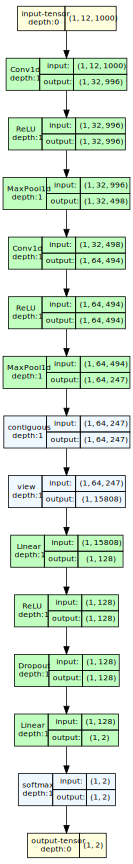

In [165]:
import torchvision
from torchview import draw_graph

input_tensor = torch.randn(1, 12, 1000).to('cuda')  # Asegúrate de que el tensor esté en CUDA si el modelo está en GPU

# Genera el gráfico
graph = draw_graph(model, input_tensor, expand_nested=True)  # Usa expand_nested=True para ver capas internas
graph.visual_graph  # Muestra el gráfico

In [167]:
graph.visual_graph.render("ecg_model_architecture", format="png", cleanup=True)



(process:7572): Pango-WARNING **: 10:44:04.352: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'ecg_model_architecture.png'

In [173]:
import hiddenlayer as hl

graph = hl.build_graph(model, input_tensor)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('hiddenlayer', format='png')

AttributeError: module 'torch.onnx' has no attribute '_optimize_trace'